# Medida 1
## Piso con ventana cerrada

 **Ubicacion**: Piso residencial (interior)
 
 **Metodologia**:
 * Medicion de los niveles de presion sonora en el interior del piso, con el fin de cuantificar la intrusion de ruido exterior (trafico, obras urbanas, vecindario etc.).
 * Toma de mediciones en tres franjas horarias diurnas: mañana (10:00-13:00), siesta (14:00-17:00) y tarde (18:00-20:00).
 * Toma de mediciones en dos franjas horarias nocturnas: tarde-noche (20:00-22:00) y noche (00:00-02:00).
 * Toma de mediciones en diferentes dıas de la semana: fin de semana (sabado) y un dıa laboral.

In [5]:
import os

# initialize directory to store json files with sampled data. 
path = 'log_files/medida_1'
if not os.path.exists(path):
    os.makedirs(path)

# global port variable
SELECTED_PORT = 'COM3'


In [6]:
import threading
import time
import math
import serial  
import logging
import json

#Listado de colores para que el texto salga bonito por pantalla.
Red = '\033[91m'
Green = '\033[92m'
Blue = '\033[94m'
Cyan = '\033[96m'
White = '\033[97m'
Yellow = '\033[93m'
Magenta = '\033[95m'
Grey = '\033[90m'
Black = '\033[90m'
Default = '\033[99m'

def format_time(unix_epoch, isFileName=False):
    """format time in unix epoch to human-readable values"""
    if isFileName:
        day = time.ctime(unix_epoch)[:3]
        formatted_time = day+time.strftime(" %Y-%m-%d %Hh%Mm%Ss", time.localtime(unix_epoch))
        return formatted_time
    formatted_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(unix_epoch))

    return str(formatted_time)

#_____________________________________________________________________________________________________________________

class AZ8922:
    """class for sonometer object"""

    def __init__(self, port):
        self.port = port
        self.ser = None
        self.running = True
        self.connected = True
        self.sound_level = []
        print(Green+"AZ8922: Iniciando la clase.\n",flush=True)

    def get_sonometry(self):
        """returns mean and max value of the measurement"""
        if self.sound_level:
            sound_level_max = max(self.sound_level)
            sound_level_min = min(self.sound_level)
            sound_level_linear = [math.pow(10,x/20) for x in self.sound_level] 
            sound_level_mean = sum(sound_level_linear) / len(sound_level_linear) 
            sound_level_mean = 20*math.log10(sound_level_mean) 
        else:
            sound_level_max = -1
            sound_level_min = -1
            sound_level_mean = -1
            
        # Check if the AZ8922 is off.
        # if self.connected and not self.sound_level: logging.warning('AZ8922 is off.')
        
        # Reset the arrays.
        self.sound_level = []
        
        # Round up.
        sound_level_mean = round(sound_level_mean,2)
        
        # logging.info(f'Sonometry AZ8922:{sound_level_mean}') 
        # logging.info('Sonometry AZ8922:%f' % sound_level_mean) 
        # if not self.connected: logging.warning('AZ8922 is disconnected.')
         
        return sound_level_mean, sound_level_max, sound_level_min

    def run_thread(self):
        """run thread to capture measurements from sonometer"""
        thread = threading.Thread(target=self.sonometro_thread, daemon=True)
        thread.start()

    def stop_thread(self):
        """stop sonometer thread"""
        self.running = False
        self.connected = False
        if self.ser is not None:
            self.ser.close()
            print(Red+"RS232 cerrando el puerto serie.\n",flush=True)
            

    def sonometro_thread(self):
        """reads values from serial port and updates sound level attribute"""
        while self.running:
            try:
                # If disconnected, check connection every 5 seconds.
                if not self.connected: time.sleep(5)
                self.ser = serial.Serial(self.port, 2400, serial.EIGHTBITS, serial.PARITY_NONE, serial.STOPBITS_ONE)
                self.connected = True
                print(Yellow+"RS232 abriendo el puerto serie.\n",flush=True)

                #Para sacar valores intermedios
                #print("Self.conected="+str(self.connected)+"\n")
                #print("self.ser.in_waiting="+str(self.ser.in_waiting)+"\n")
                #print("self.running="+str(self.running)+"\n")
                
                #while(self.connected and self.ser.in_waiting and self.running):
                while(self.connected and self.running):
                    output = self.ser.readline().decode('utf-8', 'ignore')
                    output = output.strip()
                    print(Yellow+"RS232 read data:"+str(output)+"\n",flush=True)
                    if output.startswith('N:') and output.endswith('dB'):
                        self.sound_level.append(float(output.split(':')[1].split('dB')[0]))

            except (serial.serialutil.SerialException, OSError):
                # Thread is not halted upon sensor disconnection.
                self.connected = False


## Ejemplo toma de 10 medidas

In [7]:
# User Params.
MEASURE_PERIOD = 1  # How often (seconds) we poll for measurements.
log_file = 'log_files/log.txt'
json_file = path+'/type_1 '+format_time(time.time(), True)+'.json'

# Initialization.
logging.getLogger("urllib3").setLevel(logging.WARNING) # Disable DEBUG from the "requests" module.
logging.basicConfig(format='%(levelname)s:%(asctime)s %(message)s',
                    datefmt='%d/%m/%Y %H:%M:%S', filename=log_file, level=logging.DEBUG)

running = True  # Thread running condition.


#Llamada a la función y crea objeto de la clase AZ8922
port_AZ8922 = SELECTED_PORT
sound_level_meter = AZ8922(port_AZ8922)

print(Green+"Arrancamos el proceso para medir.\n")
sound_level_meter.run_thread()

# List to store measurements.
measurements = []

# Main thread.
for x in range(10):

        time.sleep(MEASURE_PERIOD)
        current_time = format_time(time.time())

        # Polling. Esta función devuelve: sound_level_mean, sound_level_max
        sound_level_media, sound_level_maximo, sound_level_minimo = sound_level_meter.get_sonometry()
        print(Grey+"Valor medio medido="+ str(sound_level_media)+ " dB\n")
        print(Grey+"Valor máximo medido "+ str(sound_level_maximo)+ " dB\n")
        print(Grey+"Valor minimo medido "+ str(sound_level_minimo)+ " dB\n")
        #print(Magenta +"Medida(media, máximo)="+ str(sound_level)+ " dB\n" )
        print(Magenta +"Medida(media, máximo)="+ str(sound_level_media)+","+ str(sound_level_maximo)+  " dB" +Cyan+"\tTime=" + current_time+"\n")
        logging.debug("Medida(media, maximo)="+ str(sound_level_media)+","+ str(sound_level_maximo)+  " dB    Time=" + current_time+"\n")
        
        # Store the measurement in a dictionary
        measurement = {
            "time": current_time,
            "mean": sound_level_media,
            "max": sound_level_maximo,
            "min": sound_level_minimo
        }
        measurements.append(measurement)
        
# Stop the threads gracefully (close serial ports, clean LCD, etc).
logging.debug('Executing finally clause.')
running = False
sound_level_meter.stop_thread()

# Save measurements to a JSON file
with open(json_file, 'w') as f:
    json.dump(measurements, f, indent=4)
print(Green + f"Measurements saved to {json_file}\n")


AZ8922: Iniciando la clase.

Arrancamos el proceso para medir.

RS232 abriendo el puerto serie.

RS232 read data:N:037.2dB

RS232 read data:N:036.7dB

Valor medio medido=36.95 dB

Valor máximo medido 37.2 dB

Valor minimo medido 36.7 dB

Medida(media, máximo)=36.95,37.2 dB	Time=2025-03-27 00:56:33

RS232 read data:N:035.9dB

RS232 read data:N:036.3dB

RS232 read data:N:036.7dB

Valor medio medido=36.31 dB

Valor máximo medido 36.7 dB

Valor minimo medido 35.9 dB

Medida(media, máximo)=36.31,36.7 dB	Time=2025-03-27 00:56:34

RS232 read data:N:037.9dB

RS232 read data:N:035.5dB

Valor medio medido=36.78 dB

Valor máximo medido 37.9 dB

Valor minimo medido 35.5 dB

Medida(media, máximo)=36.78,37.9 dB	Time=2025-03-27 00:56:35

RS232 read data:N:036.8dB

RS232 read data:N:036.0dB

RS232 read data:N:036.7dB

Valor medio medido=36.51 dB

Valor máximo medido 36.8 dB

Valor minimo medido 36.0 dB

Medida(media, máximo)=36.51,36.8 dB	Time=2025-03-27 00:56:36

RS232 read data:N:035.9dB

RS232 read

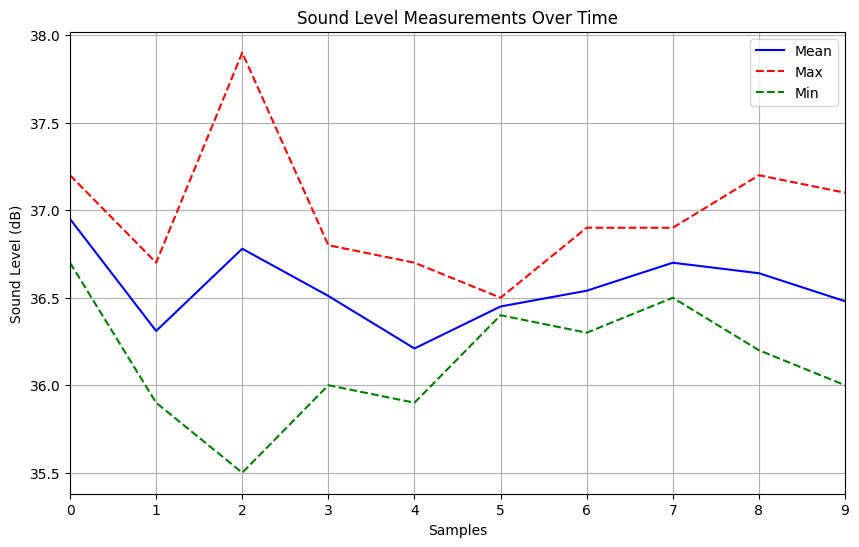

In [8]:
import matplotlib.pyplot as plt

pic_path = 'Pics/medida_1/type_1 '+format_time(time.time(), True)

# Load the measurements from the JSON file.
with open(json_file, 'r') as f:
    measurements = json.load(f)

times = [m["time"] for m in measurements]
means = [m["mean"] for m in measurements]
maxs = [m["max"] for m in measurements]
mins = [m["min"] for m in measurements]

m_number = list(range(0,len(measurements)))

# Plot the measurements
plt.figure(figsize=(10, 6))
plt.plot(m_number, means, label="Mean", color="blue")
plt.plot(m_number, maxs, label="Max", color="red", linestyle="--")
plt.plot(m_number, mins, label="Min", color="green", linestyle="--")
plt.xlim(0, len(measurements)-1)
plt.xlabel("Samples")
plt.ylabel("Sound Level (dB)")
plt.title("Sound Level Measurements Over Time")
plt.legend()
plt.grid(True)
plt.savefig(pic_path+'.png')
plt.show()


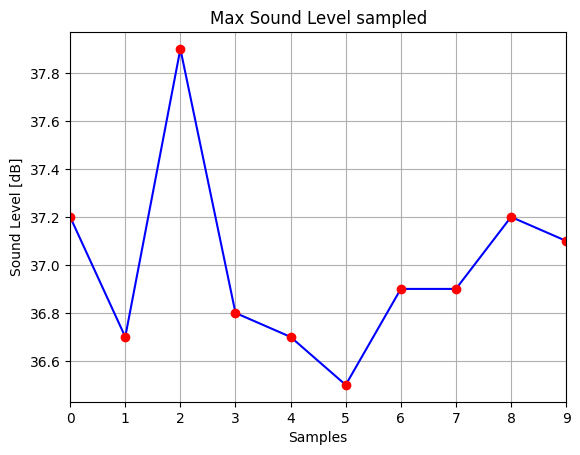

In [9]:
pic_path = 'Pics/medida_1/type_1_max '+format_time(time.time(), True)

plt.plot(maxs,'b',maxs,'ro') #Más opciones de plot aqui: https://matplotlib.org/tutorials/introductory/pyplot.html
plt.title('Max Sound Level sampled')
plt.ylabel('Sound Level [dB]')
plt.xlim(0, len(measurements)-1)
plt.xlabel('Samples')
plt.grid()
plt.savefig(pic_path+'.png')
plt.show()

## Ejemplo toma de medidas para 5 minutos

In [10]:
# User Params.
MEASURE_PERIOD = 1  # How often (seconds) we poll for measurements.
log_file = 'log_files/log.txt'
json_file = path+'/type_2 '+format_time(time.time(), True)+'.json'
MEASUREMENT_DURATION = 5 * 60  # 5 minutes


# Get the start and stop time for the measurement.
start_time = time.time()
end_time = start_time + MEASUREMENT_DURATION

# Initialization.
logging.getLogger("urllib3").setLevel(logging.WARNING) # Disable DEBUG from the "requests" module.
logging.basicConfig(format='%(levelname)s:%(asctime)s %(message)s',
                    datefmt='%d/%m/%Y %H:%M:%S', filename=log_file, level=logging.DEBUG)

running = True  


#Llamada a la función y crea objeto de la clase AZ8922
port_AZ8922 = SELECTED_PORT
sound_level_meter = AZ8922(port_AZ8922)

print(Green+"Arrancamos el proceso para medir.\n")
sound_level_meter.run_thread()

measurements = []

# Main thread.
while time.time() < end_time:
        # Sleep for the measurement period
        time.sleep(MEASURE_PERIOD)
        current_time = format_time(time.time())

        # Store the measurement in a dictionary
        measurement = {
            "time": current_time,
            "mean": sound_level_media,
            "max": sound_level_maximo,
            "min": sound_level_minimo
        }
        measurements.append(measurement)

        # Polling. Esta función devuelve: sound_level_mean, sound_level_max
        sound_level_media, sound_level_maximo, sound_level_minimo = sound_level_meter.get_sonometry()
        
        print(Grey+"Valor medio medido="+ str(sound_level_media)+ " dB\n")
        print(Grey+"Valor máximo medido "+ str(sound_level_maximo)+ " dB\n")
        print(Grey+"Valor minimo medido "+ str(sound_level_minimo)+ " dB\n")

        print(Magenta +"Medida(media, máximo, minimo)="+ str(sound_level_media)+","+ str(sound_level_maximo)+","+ str(sound_level_minimo)+  " dB" +Cyan+"\tTime=" + current_time+"\n")
        logging.debug("Medida(media, maximo, minimo)="+ str(sound_level_media)+","+ str(sound_level_maximo)+","+ str(sound_level_minimo)+  " dB    Time=" + current_time+"\n")
        
        
# Stop the threads gracefully (close serial ports, clean LCD, etc).
logging.debug('Executing finally clause.')
running = False
sound_level_meter.stop_thread()

# Save measurements to a JSON file
with open(json_file, 'w') as f:
    json.dump(measurements, f, indent=4)
print(Green + f"Measurements saved to {json_file}\n")

AZ8922: Iniciando la clase.

Arrancamos el proceso para medir.

RS232 abriendo el puerto serie.

RS232 read data:N:036.6dB

RS232 read data:N:037.4dB

Valor medio medido=37.01 dB

Valor máximo medido 37.4 dB

Valor minimo medido 36.6 dB

Medida(media, máximo, minimo)=37.01,37.4,36.6 dB	Time=2025-03-27 00:56:45

RS232 read data:N:036.5dB

RS232 read data:N:036.7dB

RS232 read data:N:037.4dB

Valor medio medido=36.88 dB

Valor máximo medido 37.4 dB

Valor minimo medido 36.5 dB

Medida(media, máximo, minimo)=36.88,37.4,36.5 dB	Time=2025-03-27 00:56:46

RS232 read data:N:036.3dB

RS232 read data:N:038.0dB

Valor medio medido=37.19 dB

Valor máximo medido 38.0 dB

Valor minimo medido 36.3 dB

Medida(media, máximo, minimo)=37.19,38.0,36.3 dB	Time=2025-03-27 00:56:47

RS232 read data:N:046.2dB

RS232 read data:N:037.5dB

RS232 read data:N:036.1dB

Valor medio medido=41.16 dB

Valor máximo medido 46.2 dB

Valor minimo medido 36.1 dB

Medida(media, máximo, minimo)=41.16,46.2,36.1 dB	Time=2025-0

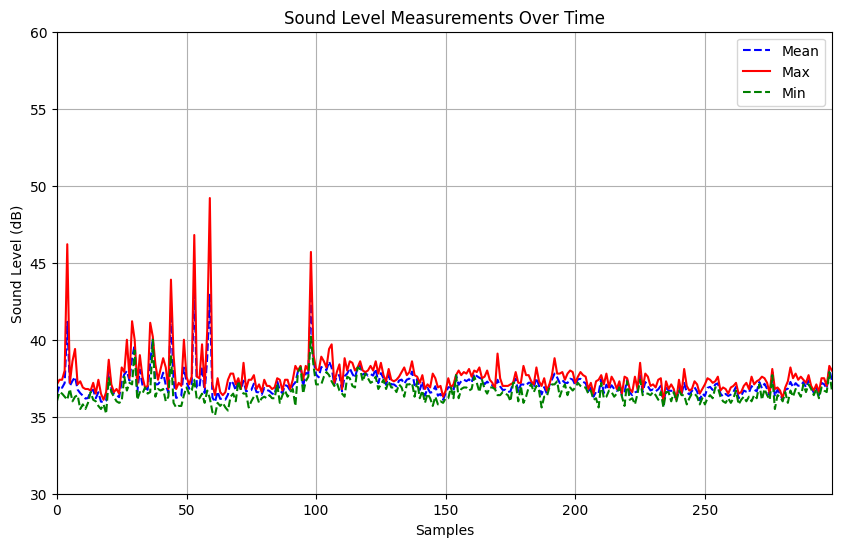

In [11]:
import matplotlib.pyplot as plt

pic_path = 'Pics/medida_1/type_2 '+format_time(time.time(), True)

# Load the measurements from the JSON file.
with open(json_file, 'r') as f:
    measurements = json.load(f)

times = [m["time"] for m in measurements]
means = [m["mean"] for m in measurements]
maxs = [m["max"] for m in measurements]
mins = [m["min"] for m in measurements]

m_number = list(range(0,len(measurements)))

# Plot the measurements
plt.figure(figsize=(10, 6))
plt.plot(m_number, means, label="Mean", color="blue", linestyle="--")
plt.plot(m_number, maxs, label="Max", color="red")
plt.plot(m_number, mins, label="Min", color="green", linestyle="--")
plt.xlim(0, len(measurements)-1)
plt.ylim(30, 60)
plt.xlabel("Samples")
plt.ylabel("Sound Level (dB)")
plt.title("Sound Level Measurements Over Time")
plt.legend()
plt.grid(True)
plt.savefig(pic_path+'.png')
plt.show()


## Ejemplo de lectura directa del Serial y almacenamiento en un vector.

In [12]:
import serial
import math

#Listado de colores para que el texto salga bonito por pantalla.
Red = '\033[91m'
Green = '\033[92m'
Blue = '\033[94m'
Cyan = '\033[96m'
White = '\033[97m'
Yellow = '\033[93m'
Magenta = '\033[95m'
Grey = '\033[90m'
Black = '\033[90m'
Default = '\033[99m'


# Sound level meter.
port_AZ8922 = SELECTED_PORT
ser = serial.Serial(port_AZ8922,2400, serial.EIGHTBITS, serial.PARITY_NONE, serial.STOPBITS_ONE)  # open serial port


# Reset the arrays.
sound_level = []

#while(ser.connected):
for x in range(10):
    output = ser.readline().decode('utf-8', 'ignore')
    output = output.strip()
    #print("RS232 read data:"+str(output)+"\n")
    if output.startswith('N:') and output.endswith('dB'):
        salida_texto=float(output.split(':')[1].split('dB')[0])
        sound_level.append(salida_texto) # Para concatenar los valores y formar un Vector/Array
        print("RS232 db="+str(salida_texto)+"\n")     
    
ser.close()  #Cerramos el puerto porque no puede quedar cerrado. En el caso de que al ejecutar el código el 
#Serial se quede abierto y no se pueda volver a ejecutar el código porque el puerto está abierto. Se copia
#esta línea en una ventana nueva y se ejecuta. Con eso se cierra el Serial y ya se puede volver a abrir.


# Round up.
#sound_level_mean = round(sound_level_mean,2)
#print("Sound Level(Media)="+str(sound_level_mean)+"\n") 

#Calculamos el máximo en dB
sound_level_max = max(sound_level) #Esto es el máximo de un vector
print(Green + "Sound Level(Max)="+str(sound_level_max)+" db\n") 

#Calculamos el mínomo en dB
sound_level_min = min(sound_level)
print(Magenta+"Sound Level(Min)="+str(sound_level_min)+" db\n") 

#Calculamos la suma de los valores sin decibelios
sound_level_linear = [math.pow(10,x/20) for x in sound_level] 
print(Blue +"Sound Level(linear)="+str(sound_level_linear)+"\n") 

#Pasamos la suma de lo medido en dB
sound_level_mean = sum(sound_level_linear) / len(sound_level_linear) 
sound_level_mean = 20*math.log10(sound_level_mean)
print(Red + "Sound Level(Mean)="+str(sound_level_mean)+" db\n") 




RS232 db=37.1

RS232 db=38.1

RS232 db=37.0

RS232 db=37.0

RS232 db=37.8

RS232 db=37.6

RS232 db=36.1

RS232 db=37.3

RS232 db=37.4

RS232 db=37.4

Sound Level(Max)=38.1 db

Sound Level(Min)=36.1 db

Sound Level(linear)=[71.6143410212902, 80.35261221856173, 70.79457843841381, 70.79457843841381, 77.62471166286916, 75.8577575029184, 63.82634861905489, 73.28245331389037, 74.13102413009173, 74.13102413009173]

Sound Level(Mean)=37.295078540634044 db

